# Dimensionality reduction for linguists
## A practical introduction
Matthew Faytak 

UCLA

## Making sense of linguistic data

Linguistic data is often **high-dimensional** and **collinear**. Sometimes we also do not know **which measurements** to choose in order to characterize the behavior we would like to analyze.

I will suggest **dimensionality reduction** as a solution to both of these problems.

## Dimensionality reduction

Take very complicated basis data and:

* Extract important types of variation (across multiple variables)
* Re-express data in terms of these types of variation
* Reduce the number of descriptors needed to characterize the data

## Further reading

If you are interested in the theory and can handle a little mathematics, I suggest reading:

* Shlens, J. (2014). A Tutorial on Principal Component Analysis. arXiv: https://arxiv.org/abs/1404.1100.

## Today's tutorial

Today we will focus on:

* **Implementing** PCA and LDA in python using scikit-learn
* A **basic understanding** of the outputs of dimensionality reduction methods

## Getting started

Before doing anything else, our imports. First, the basics:

In [1]:
import os, re, glob # for file-getting
from hashlib import sha1
import numpy as np # for numerical array handling, Matlab-style
import pandas as pd # for handling tabular data, R-style

Followed by some imports for plotting:

In [2]:
import matplotlib.pyplot as plt # allows us to display images in the notebook
%matplotlib inline 
plt.rcParams['figure.figsize'] = [
    x*1.5 for x in plt.rcParams['figure.figsize']
] # enlarge the size of all images we make

Finally, our dimensionality reduction utilities.

In [3]:
# note: sklearn is short for scikit-learn!
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## PCA 1: a simple data set

Let's examine our first data set: phonological characteristics of Wu dialect sites taken from Qian Nairong's 钱乃荣 notable book 当代吴语研究 (1992)

* Mostly concern **mergers** or **developments** of particular reconstructible sounds
* **0** is given for the conservative version, **1** for the innovative version, and **0.5** for a mixture or intermediate stage

Thanks to Yiqiao Liu 刘伊乔 (UCLA), who assisted with extracting this data from the source

In [165]:
qian = pd.read_csv("qiandata.csv")
qian.head(5)

,name,label,lat,long,1_s_pal,2_dz_len,3_z_devoi,4_v_init,5_v_init,6_geng_gang,8_lei_lai,9_lai_lan,10_lei_lou,12_mm,13_da_de,14_xue,15_kan,19_xu,22_zh_affric,29_rusheng_k
0,Yixing,YX,31.34063,119.82330,1.0,0.0,0.0,0.5,0.5,1.0,0,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,Liyang,LY,31.41691,119.48421,1.0,0.0,0.0,1.0,0.5,0.0,0,0.0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.5
2,Jintan,JT,31.72324,119.59789,1.0,1.0,1.0,0.0,0.5,0.0,1,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Danyang,DY,32.01021,119.60643,1.0,0.0,0.5,0.5,0.5,0.0,1,1.0,1,0.0,0.0,0.5,1.0,1.0,1.0,0.0
4,Danyang-tongjia,TJ,32.09286,119.78629,1.0,0.0,0.5,0.5,0.5,0.0,1,0.0,1,0.0,0.0,1.0,1.0,1.0,1.0,0.0


We can run PCA on this data, though usually we will **prefer to use continuous data** 

* This data is **categorical**, converted to a numerical scale
* Opinions vary on whether this meets all assumptions inherent to PCA!
* But it will do as an introductory example

Regardless, we first have to separate out the numerical part of our data (the observations themselves) from the metadata part.

In [166]:
metadata = qian.iloc[:,0:4] # dialect site names
obs = qian.iloc[:,4:] # data without dialect site names - we have 16 characteristics for 32 dialect sites
obs.shape

(32, 16)

Now, let's run PCA on the numerical part. We'll extract 10 components to start, and show how much variance each explains. 

In [207]:
ncom = 10
pca = PCA(n_components=ncom) # create a PCA analysis object with our desired number of components
pca.fit(obs) # run specified PCA on the observations

print("PCs explain", pca.explained_variance_ratio_)
print("Total explained is", sum(pca.explained_variance_ratio_)) # PCs 1 and 2 are especially informative

PCs explain [ 0.25601966  0.15196578  0.11359927  0.09781425  0.07929686  0.06867689
  0.05005386  0.042496    0.03772138  0.02225591]
Total explained is 0.919899859361


## Interpreting variance explained

The goal of PCA is to **maximize variance** in the basis data **explained by the model** 

* However, we also want to **minimize the complexity** of the analysis
* This looks like **too many components**, some of which **explain little** (PCs 5-10)

Let's visualize the variance explained as we add PCs:

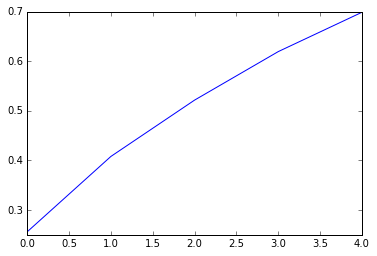

In [190]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Let's arbitrarily place the cutoff at **5 PCs** 

* This doesn't actually matter too much, since we'll only be inspecting the first two or three PCs here
* These 5 PCs will be the same as the first 5 in the first PCA we did with 10 PCs
* After all, the data hasn't changed, so the variation uncovered will be the same

In [211]:
ncom = 5 # reduce the number of components extracted, and try again
pca = PCA(n_components=ncom)
pca.fit(obs)

print("PCs explain", pca.explained_variance_ratio_) # same 5 PCs as the first 5 last time
print("Total explained is", sum(pca.explained_variance_ratio_)) # now explains about 70% of variance, which is still good

PCs explain [ 0.25601966  0.15196578  0.11359927  0.09781425  0.07929686]
Total explained is 0.698695818131


## Exploring the new data

From PCA we get a series of principal components (PCs), which are **ordered** by how much variation in the basis data they explain 

* PC1 always explains the most, PC2 the second-most, and so on
* Each PC represents an important "axis" of variation in the data, in terms of **multiple input variables**

In terms of our data from Qian (1992), we can:

* Determine the major kinds of variation in the Wu dialect phonologies
* See where dialect sites lie on these dimensions

Let's take a closer look at the objects we get from the PCA. For starters, `pca.components_`, an attribute of the `pca` object we defined above, contains our **eigenvectors**

* Each has 16 elements, one for each characteristic of the numeric data we fed to the PCA
* Each characteristic is a **column** in the data frame we displayed earlier
* Summarize properties of the data, not the individual observations

In [186]:
pca.components_.shape # 5 PCs times 16 attributes

(5, 16)

If we inspect the eigenvectors, we will see that they consist of a series of positive and negative numbers. We can plot these using a color scheme (blue = high, red = low) to see what kind of variation our eigenvectors actually encode.

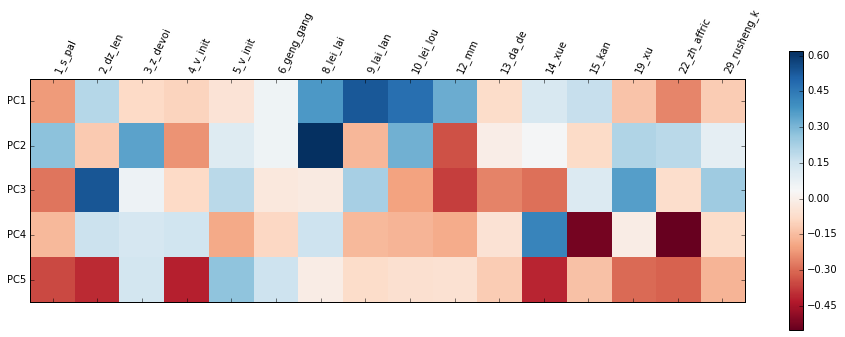

In [212]:
plt.matshow(pca.components_,cmap='RdBu')
plt.yticks([0,1,2,3,4],['PC1','PC2','PC3', 'PC4', "PC5"],fontsize=10)
plt.colorbar()
plt.xticks(range(len(obs.columns)),obs.columns,rotation=65,ha='left')
plt.show() 
# here we see high PC1 indicates a tendency to merge the mid non-back vowels, e.g. items 8, 9, and 19
#   these happen to covary with [dz] onsets leniting (becoming [z])
# what about PC2? PC3?

Eigenvectors *themselves* don't characterize what our individual observations (dialect sites) are **actually like**, however. To do this we need to calculate our **eigenvalues**, sometimes called **PC scores**

* Our basis data, but transformed to be in terms of the eigenvectors
* This is actually quite simple in `sklearn`!

In [188]:
pc_out = pca.transform(obs) # transform the data to the new basis
pc_headers = ["pc"+str(i+1) for i in range(0,ncom)] 
headers = ["names","label","lat","long"] + pc_headers # make a list of column headers
qian = pd.DataFrame(np.column_stack([metadata, pc_out]), columns=headers)
qian.head(5) # inspecting the first five rows

,names,label,lat,long,pc1,pc2,pc3,pc4,pc5
0,Yixing,YX,31.3406,119.823,-0.712983,-0.319826,-0.211071,-0.876265,0.0467505
1,Liyang,LY,31.4169,119.484,-1.0744,-0.0736921,-0.0203777,-0.148093,-0.75748
2,Jintan,JT,31.7232,119.598,-0.353533,0.8446,0.470039,1.26053,-0.0755431
3,Danyang,DY,32.0102,119.606,0.297799,0.92878,0.0860358,-0.491177,-0.327765
4,Danyang-tongjia,TJ,32.0929,119.786,-0.168036,1.10769,-0.28921,-0.127115,-0.463207


Let's make a plot to see how our varieties **cluster** in their eigenvalues/scores for the first two PCs, which are especially informative. We'll add the third PC as color.

* Note that the PCs are **uncorrelated**: solves our collinearity problem!
* Taihu Wu languages form two clusters in lower left, plus cluster at right

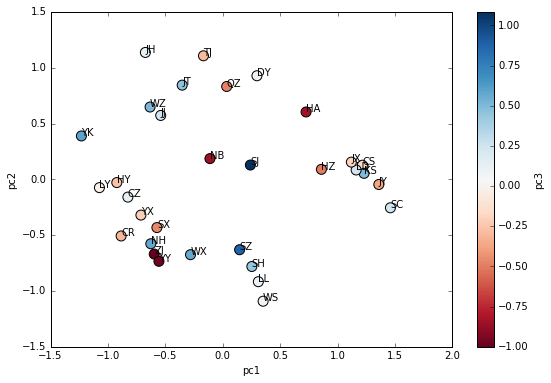

In [213]:
fig,ax = plt.subplots()
qian.plot(x='pc1', y='pc2', kind='scatter', c='pc3', s=100, ax=ax, cmap="RdBu")
for k, v in qian.iterrows():
    ax.annotate(v.label, (v.pc1, v.pc2),)

Since this is spatial data we might also want to rearrange it in terms of latitude and longitude. Let's practice interpreting:

* What does this map tell us about "Northern Wu" versus "Southern Wu"? The Shanghai area?
* What dialect regions score similarly to one another on PC1? PC2?
* What is going on with the far northwest, near Danyang and Jintan?

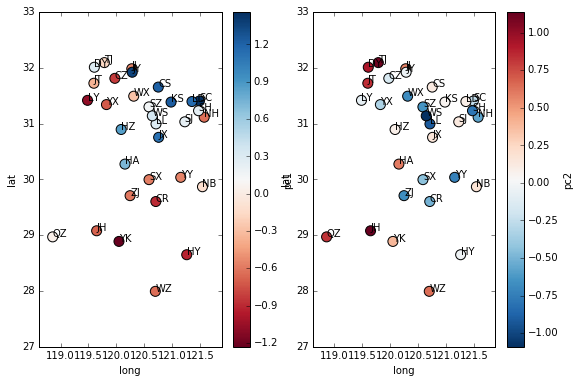

In [214]:
# TODO fix dimensions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
qian.plot(x='long', y='lat', kind='scatter', c='pc1', s=100, ax=ax1, cmap="RdBu")
qian.plot(x='long', y='lat', kind='scatter', c='pc2', s=100, ax=ax2, cmap="RdBu_r")
for k, v in qian.iterrows():
    ax1.annotate(v.label, (v.long, v.lat),)
    ax2.annotate(v.label, (v.long, v.lat),)
ax1.axes.set_aspect('equal', 'datalim')
ax2.axes.set_aspect('equal', 'datalim')

## PCA 2: a more complicated data set

We can extend this relatively simple PCA-based analysis to a much more complex data type: articulatory phonetic data

* Here, an ultrasound data set which I have collected with an advisee, Suyuan Liu 柳苏源 (UCLA) as part of her undergraduate honors thesis
* Thanks to Suyuan for her permission to use this data here

## The problem

Speakers of various Chinese dialects have been reported to **merge** coda nasals /n/ and /ŋ/. In some cases this has been reported to extend to Standard Mandarin:

* Taiwanese Mandarin, under influence of Hokkien (Chiu et al. to appear)
* Wu dialect speakers' L2 Mandarin, under influence of Wu dialects (Luo 2014)

## Specifics

Standard Mandarin rhymes that minimally contrast for nasal coda are the following:

* /in/ versus /iŋ/
* /en/ versus /eŋ/ (where /e/ is a back vowel)
* /an/ versus /aŋ/

(Yes, there are slight differences in vowel quality for some speakers)

## The data

We collected ultrasound data at UCLA on the nasal coda articulations of **two groups** of Standard Mandarin speakers:

* **Control** Mandarin speakers, who only had exposure to Standard Mandarin (and English)
* **Shanghainese** speakers who also speak Mandarin (and English)

Today we'll be examining some representative speakers from both groups

## Getting started

First we'll read in our data. This is a bit different from last time

* Our numerical data (the ultrasound images) are stored in `.npy` files as 3-dimensional numerical arrays
* Our metadata are stored in `.pickle` files, a Python-friendly plaintext format

Let's read in Subj. 5, a control speaker:

In [4]:
data_in = "caches/NC05/frames_proc.npy"
data = np.load(data_in)
metadata_in = "caches/NC05/frames_proc_metadata.pickle"
md_pre = pd.read_pickle(metadata_in)

# some sanity checks on data checksums
assert(len(md_pre) == data.shape[0]) # make sure one md row for each frame
assert(md_pre.loc[0, 'sha1_filt'] == sha1(data[0].ravel()).hexdigest()) # checksums
assert(md_pre.loc[len(md_pre)-1,'sha1_filt'] == sha1(data[-1].ravel()).hexdigest())
# get rid of hash-related columns after checking
md = md_pre.iloc[:,0:11].copy()

We also need to get rid of some data concerning the preceding vowels (not our focus here)

In [5]:
# let's also get rid of the data which aren't about the nasals
# disregard this warning
nas_list = md['phone'].isin(['n','ng'])
nas_mask = np.array(nas_list, dtype=bool)
pca_md = md[nas_mask]
pca_data = data[nas_mask]

Our metadata look like this (the **timestamp** is the unique ID for each trial):

In [19]:
pca_md.head(5)

,speaker,timestamp,time,pulseidx,width,height,phone,sup,stim,before,after
1,NC05,2019-03-15T154820-0700,2.280913,181,64,946,n,NA,YAJIN,i,sp
3,NC05,2019-03-15T154826-0700,2.115868,168,64,946,n,NA,QINGZHEN,e,sp
5,NC05,2019-03-15T154831-0700,2.243541,178,64,946,ng,NA,SHUISHENG,e,sp
7,NC05,2019-03-15T154835-0700,2.115000,168,64,946,n,NA,QUANMIN,i,sp
9,NC05,2019-03-15T154839-0700,2.365000,188,64,946,ng,NA,PANGGUANG,ua,sp


And our numerical data, which at first doesn't look very interesting ...

In [23]:
pca_data[1] # 2nd "slice" of the 3D array, or the frame corresponding to the second row in the table

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

... is actually the ultrasound image data itself, stored as **pixel values**

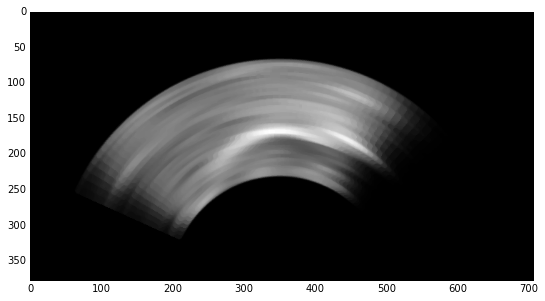

In [24]:
plt.imshow(np.fliplr(pca_data[1]), cmap="Greys_r")
# as always, left is front

Running the PCA looks very much like last time, except that our numerical data has already been separated out. We also need to take the initial step of "flattening" the array data into a **very long list**.

In [19]:
image_shape = pca_data[0].shape
frames_reshaped = pca_data.reshape([
        pca_data.shape[0],
        pca_data.shape[1] * pca_data.shape[2]
        ])
frames_reshaped.shape # 239 observations of nasals, times 266,162 pixels!

(239, 266162)

As before, we define the number of components and create the model object, then fit it to the data.

In [7]:
ncomp=10
pca = PCA(n_components=ncomp) 
pca.fit(frames_reshaped)

print("PCs explain", pca.explained_variance_ratio_) # 
print("Total explained is", sum(pca.explained_variance_ratio_)) # about 80% of variance, which is great

PCs explain [ 0.39063468  0.14969331  0.07457674  0.05179613  0.03430684  0.02444661
  0.01825087  0.01712551  0.01251549  0.01200876]
Total explained is 0.785354931412


## Exploring the new data (again)

The eigenvectors we get from this PCA are somewhat different in nature compared to the Qian (1992) data, since they are **inherently spatial** - they depict the actual space of the oral cavity

* We will need to "unflatten" the eigenvectors, since they are now long lists and our basis data are images
* We will need to scale them so that they will plot as an image

The resulting objects are sometimes called **eigentongues** (Hueber et al 2007)

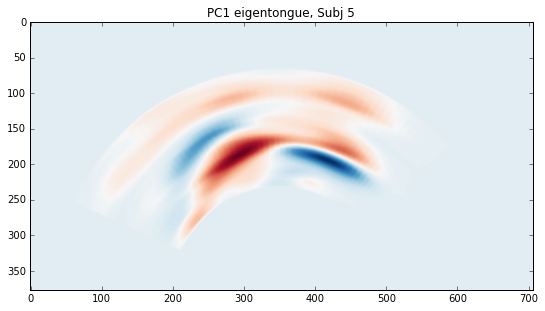

In [14]:
dd = pca.components_[0].reshape(image_shape)
mag = np.max(dd) - np.min(dd)
et = (dd-np.min(dd))/mag*255
plt.title("PC1 eigentongue, Subj 5")
plt.imshow(np.fliplr(et), cmap="RdBu")
# How should we interpret this eigentongue? Remember, right is front.

Let's also get the eigenvalues/PC scores before proceeding further, since these will help us get a better understanding of the data. We will add them to our metadata as before.

In [18]:
pca_out = pca.transform(frames_reshaped) # the eigenvalues

pc_headers = ["pc"+str(i+1) for i in range(0,ncomp)] # some headers for the tabular data
meta_headers = pca_md.columns.values
headers = list(meta_headers) + pc_headers
metadata = pca_md.values
out_df = np.column_stack((metadata, pca_out))
out_df = pd.DataFrame(out_df, columns=headers)
out_df.head(5)

,speaker,timestamp,time,pulseidx,width,height,phone,sup,stim,before,...,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,NC05,2019-03-15T154820-0700,2.28091,181,64,946,n,NA,YAJIN,i,...,347.171,-4265.22,1740.23,-570.755,162.09,-507.062,236.501,-238.099,-261.035,-996.59
1,NC05,2019-03-15T154826-0700,2.11587,168,64,946,n,NA,QINGZHEN,e,...,-557.402,-3692.49,967.435,-1227.34,728.435,277.571,-33.4398,-20.2771,14.493,-881.377
2,NC05,2019-03-15T154831-0700,2.24354,178,64,946,ng,NA,SHUISHENG,e,...,2065.92,213.487,1505.88,-737.37,1254.05,-118.146,665.932,359.131,30.9783,-723.436
3,NC05,2019-03-15T154835-0700,2.115,168,64,946,n,NA,QUANMIN,i,...,-1280.27,-1342.89,2985.83,606.416,-1306.48,76.5201,1251.78,-362.507,-911.362,12.9611
4,NC05,2019-03-15T154839-0700,2.365,188,64,946,ng,NA,PANGGUANG,ua,...,4327.03,-2392.71,186.003,369.653,-1023.54,756.542,-1048.83,1186.68,749.781,-221.232


Plotting the PC scores to look for clustering, it seems that this speaker produces two very distinct nasal codas. This is expected, since they are a control speaker.

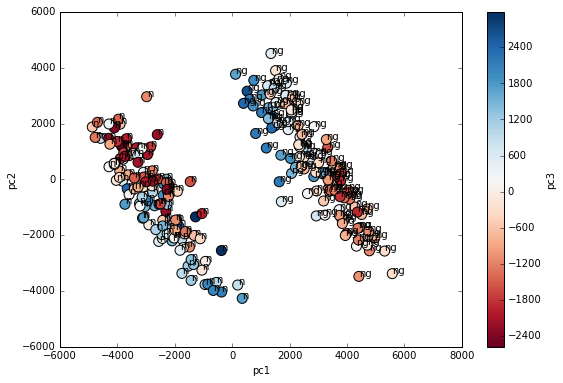

In [21]:
fig,ax = plt.subplots()
out_df.plot(x='pc1', y='pc2', kind='scatter', c='pc3', s=100, ax=ax, cmap="RdBu")
for k, v in out_df.iterrows():
    ax.annotate(v.phone, (v.pc1, v.pc2),)
# Thinking back to the structure of the data, what might PC3 encode?

## Reconstruction of data

With our eigenvalues and our eigenvectors, we can **reconstruct** our data in a way that may help to make sense of PCA as a **decomposition** process.

Let's return to the second frame, which we looked at in its unprocessed form above. Its eigenvalues are:

In [30]:
out_df.iloc[1][11:] # recall: being low on PC1 and PC2 tends to mean "alveolar"

pc1    -557.402
pc2    -3692.49
pc3     967.435
pc4    -1227.34
pc5     728.435
pc6     277.571
pc7    -33.4398
pc8    -20.2771
pc9      14.493
pc10   -881.377
Name: 1, dtype: object

We'll start by displaying only the contribution of PC1's eigenvector to this frame, effectively **reversing** the decomposition that was carried out to produce the eigenvector for PC1. To do this we **multiply the eigenvector by this observation's matching eigenvalue**.

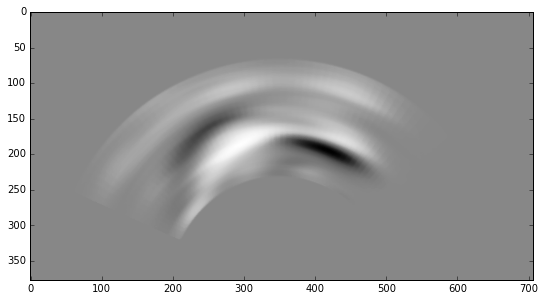

In [34]:
recon = out_df.iloc[1]['pc1'] * pca.components_[0]
recon = recon.reshape(image_shape)
plt.imshow(np.fliplr(recon), cmap="Greys_r")

Next, we can add PC2's contribution back in.

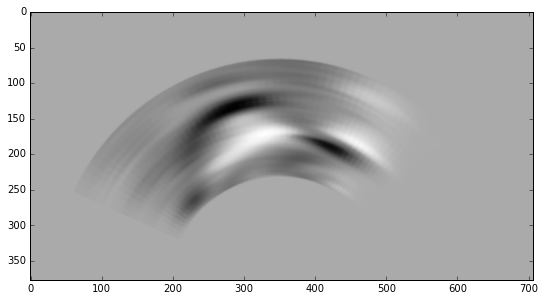

In [39]:
recon = ((out_df.iloc[1]['pc1'] * pca.components_[0]) + 
         (out_df.iloc[1]['pc2'] * pca.components_[1])
        )
recon = recon.reshape(image_shape)
plt.imshow(np.fliplr(recon), cmap="Greys_r")

And now PC3 (at this point, the components each contribute a little less than the one before):

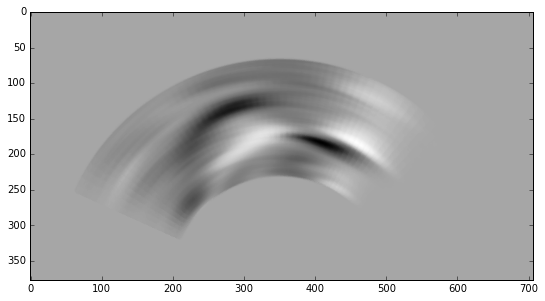

In [40]:
recon = ((out_df.iloc[1]['pc1'] * pca.components_[0]) + 
         (out_df.iloc[1]['pc2'] * pca.components_[1]) +
         (out_df.iloc[1]['pc3'] * pca.components_[2])
        )
recon = recon.reshape(image_shape)
plt.imshow(np.fliplr(recon), cmap="Greys_r")

And if we want, we can carry this out for all 10 PCs (we will stop at 6 here):

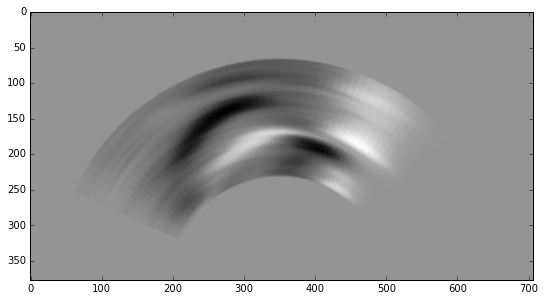

In [41]:
recon = ((out_df.iloc[1]['pc1'] * pca.components_[0]) + 
         (out_df.iloc[1]['pc2'] * pca.components_[1]) +
         (out_df.iloc[1]['pc3'] * pca.components_[2]) +
         (out_df.iloc[1]['pc4'] * pca.components_[3]) +
         (out_df.iloc[1]['pc5'] * pca.components_[4]) +
         (out_df.iloc[1]['pc6'] * pca.components_[5])
        )
recon = recon.reshape(image_shape)
plt.imshow(np.fliplr(recon), cmap="Greys_r")

This compares reasonably well with the basis data, if we focus on the **bright part**:

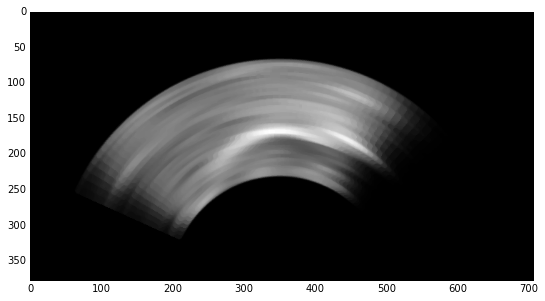

In [42]:
plt.imshow(np.fliplr(pca_data[1]), cmap="Greys_r")
# as always, left is front

## So what?

To demonstrate why this is useful, we will take **a digression into more of these images** before taking a break and moving on to a brief discussion of **linear discriminant analysis** (LDA).

## References

Upon request